In [1]:
import math
import numpy as np
import tbplas as tb
import sisl
from pathlib import Path

/home/alapena/miniconda3/envs/tbplas/lib/python3.12/site-packages/tbplas/cython/__init__.py:54: UserWarning: C++ hdf5 extension not found. HDF5 IO not usable.
  warnings.warn("C++ hdf5 extension not found. HDF5 IO not usable.")


In [2]:
def add_orbitals(cell: tb.PrimitiveCell, positions, onsites, labels) -> None:
    """
    Add orbitals to the model.

    There are n_atoms atoms, with n_orbs orbitals each in that same position. We will extract those orbitals from the atom info.
    """
    for i in range(positions.shape[0]):
        n_orbs = len(labels[i])
        for j in range(n_orbs):
            cell.add_orbital_cart(positions[i], unit=tb.ANG, energy=onsites[i*n_orbs+j], label=labels[i][j])


def add_hopping_terms(cell: tb.PrimitiveCell, iscs, orbs_in, orbs_out, hoppings) -> None:
    n_hops = len(iscs)
    for i in range(n_hops):
        cell.add_hopping(rn=iscs[i], orb_i=orbs_in[i], orb_j=orbs_out[i], energy=hoppings[i])

In [3]:
debug_mode=False

path = Path("../../dataset/SHARE_OUTPUTS_2_ATOMS/41f7-3b57-4367-959e-f7b2cc71bc23")
file = sisl.get_sile(path / "aiida.HSX")
geometry = file.read_geometry()

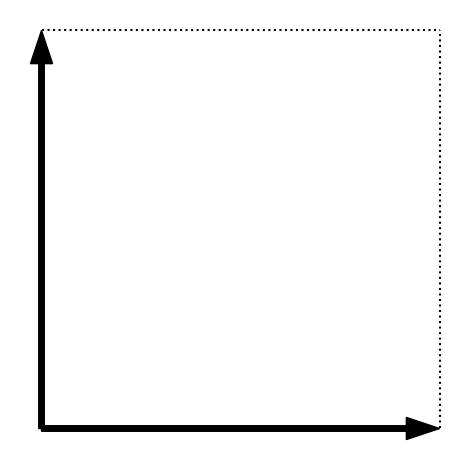

In [4]:
# Define tight binding model for tbplas

# Empty cell
vectors = geometry.cell
cell = tb.PrimitiveCell(vectors, unit=tb.ANG)
cell.plot()

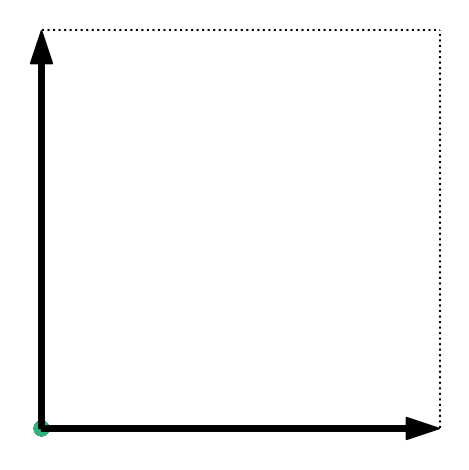

In [5]:
# Add orbitals
positions = geometry.xyz
labels = [[orb.name() for orb in atom] for atom in geometry.atoms]

# To add the orbitals we need the onsite energies.
h = file.read_hamiltonian()
h_mat = h.tocsr().tocoo()

rows = h_mat.row
cols = h_mat.col
data = h_mat.data

# Main diagonal length:
n_diag = min(h_mat.shape[0], h_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# onsites = 
add_orbitals(cell, positions, onsites, labels)
cell.plot()

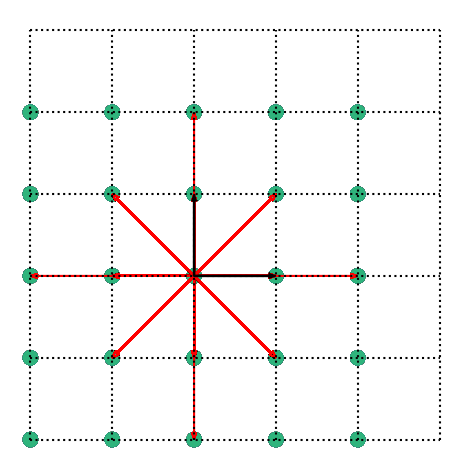

In [6]:
# Add hopping terms.
# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = len(positions)
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
        

add_hopping_terms(cell, iscs, orbs_in, orbs_out, hoppings)
cell.plot()


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : sample

Using Eigen backend for diagonalization.


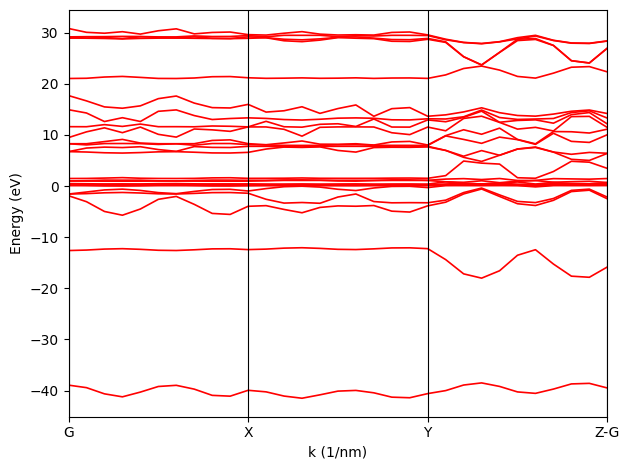

In [7]:
# Calculations

# Define a path in k-space
k_dir_x = geometry.rcell[:,0]
k_dir_y = geometry.rcell[:,1]
k_dir_z = geometry.rcell[:,2]
k_points = np.array([
    [0.0, 0.0, 0.0],    # Gamma
    k_dir_x,
    k_dir_x + k_dir_y,
    k_dir_x + k_dir_y + k_dir_z
])
k_points = np.array([[0, 0, 0], [0, 0, 1]]) if debug_mode else k_points
k_label = ["G", "X", "Y", "Z-G"] if not debug_mode else ["G", "X-G"]

n_ks = 10
k_path, k_idx = tb.gen_kpath(k_points, [n_ks, n_ks, n_ks])


# Bands
use_diag_solver = True
if use_diag_solver:
    solver = tb.DiagSolver(cell)
    solver.config.k_points = k_path
    # solver.config.prefix = "graphene"
    k_len, bands = solver.calc_bands()
else:
    k_len, bands = tb.calc_bands(cell, k_path, prefix="graphene")

vis = tb.Visualizer()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)



Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : sample

Using Eigen backend for diagonalization.


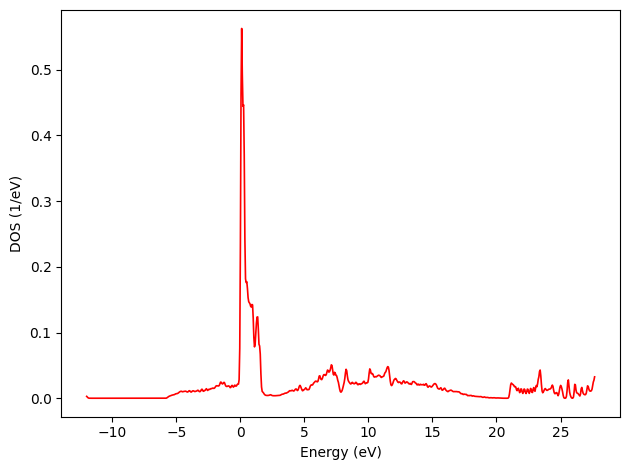

In [8]:
# DOS
k_mesh = tb.gen_kmesh((3*n_ks, 3*n_ks, 3*n_ks))  # Uniform meshgrid
e_min = np.min(data)
e_max = np.max(data)
if use_diag_solver:
    solver = tb.DiagSolver(cell)
    solver.config.k_points = k_mesh
    # solver.config.prefix = "graphene"
    solver.config.e_min = e_min
    solver.config.e_max = e_max
    energies, dos = solver.calc_dos()
else:
    energies, dos = tb.calc_dos(cell, k_mesh, e_min=-10, e_max=10)

vis = tb.Visualizer()
fig_dos = vis.plot_dos(energies, dos)